In [53]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [55]:
# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\232pa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\232pa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
# Load dataset
df = pd.read_csv("data_news.csv")


In [59]:
# Drop the 'links' column
df.drop(columns=['links'], inplace=True)

In [61]:
# Fill missing keywords with an empty string
df.loc[:, 'keywords'] = df['keywords'].fillna('')

In [63]:
# Combine text columns
df['text'] = df['headline'] + " " + df['short_description'] + " " + df['keywords']

In [65]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [67]:
# Optimized text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-z0-9\s]', '', text.lower())  # Fast text cleaning
    words = text.split()  # Fast tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Stopword removal & lemmatization
    return words

In [69]:
# Apply preprocessing
df['tokenized_text'] = df['text'].apply(preprocess_text)

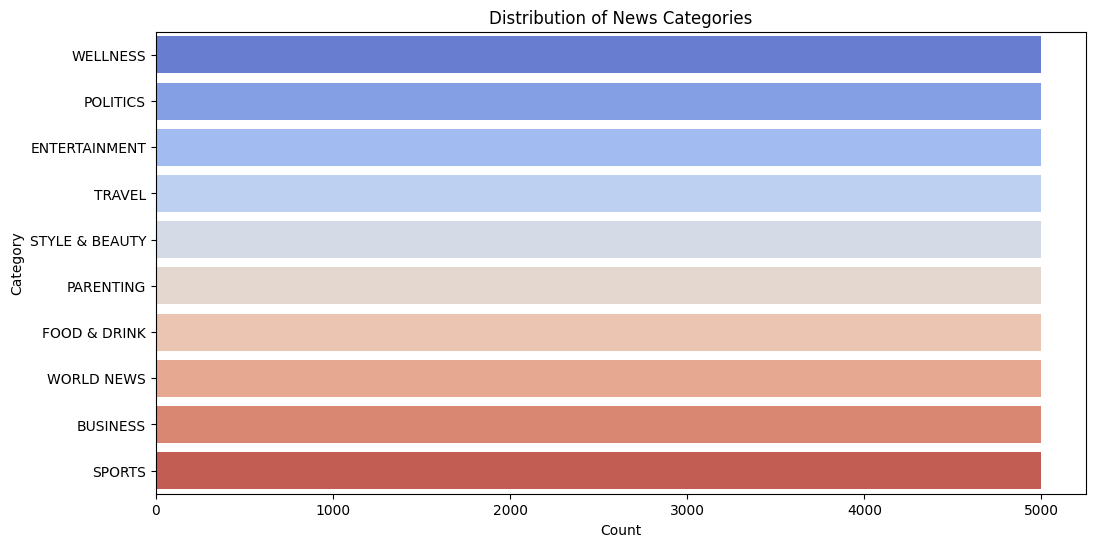

In [71]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.countplot(y=df['category'], order=df['category'].value_counts().index, hue=df['category'], palette='coolwarm', legend=False)
plt.title('Distribution of News Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


In [73]:
# Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=df['tokenized_text'], vector_size=100, window=5, min_count=2, workers=4)


In [75]:
# Convert sentences to feature vectors
def get_avg_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df['word2vec_features'] = df['tokenized_text'].apply(lambda x: get_avg_word2vec(x, word2vec_model, 100))
X = np.vstack(df['word2vec_features'].values)

In [77]:
# Normalize data to remove negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [79]:
# Encode category labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

In [81]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Train Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [85]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [87]:
# Train SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [89]:
# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Performance on Test Data:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

evaluate_model(y_test, y_pred_nb, "Naive Bayes")
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_svm, "SVM")

print("Feature extraction, model training, and evaluation complete.")



Naive Bayes Performance on Test Data:
Accuracy: 0.3618
Precision: 0.3685
Recall: 0.3618
F1 Score: 0.3562
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.23      0.22       955
           1       0.24      0.15      0.19       985
           2       0.49      0.52      0.50      1021
           3       0.36      0.44      0.39      1030
           4       0.54      0.31      0.40      1034
           5       0.28      0.39      0.32       995
           6       0.53      0.46      0.49       986
           7       0.35      0.28      0.31      1008
           8       0.29      0.24      0.26      1009
           9       0.37      0.60      0.46       977

    accuracy                           0.36     10000
   macro avg       0.37      0.36      0.36     10000
weighted avg       0.37      0.36      0.36     10000

Confusion Matrix:
[[218  36  26 102  59 103  11  46 165 189]
 [ 62 151  37  78  38 276 122  88  37  96]
 [ 53  3

In [109]:
# Save cleaned data as Excel file
df[['category', 'tokenized_text', 'word2vec_features']].to_excel("cleaned_data_news.xlsx",index=False,engine='openpyxl')
print("Preprocessing, feature extraction, and classification complete. Cleaned data saved as 'cleaned_data_news.xlsx'.")
df.to_csv("cleaned_data_news.csv", index=False, encoding='utf-8')


Preprocessing, feature extraction, and classification complete. Cleaned data saved as 'cleaned_data_news.xlsx'.


In [119]:
# Function to classify new articles
def classify_new_article():
    text = input("Enter a news article: ")
    processed_text = preprocess_text(text)
    feature_vector = get_avg_word2vec(processed_text, word2vec_model, 100).reshape(1, -1)
    feature_vector = scaler.transform(feature_vector)  # Apply the same scaling
    
    # Get predictions
    prediction_nb = nb_model.predict(feature_vector)
    prediction_lr = lr_model.predict(feature_vector)
    prediction_svm = svm_model.predict(feature_vector)
    
    predicted_category_nb = label_encoder.inverse_transform(prediction_nb)[0]
    predicted_category_lr = label_encoder.inverse_transform(prediction_lr)[0]
    predicted_category_svm = label_encoder.inverse_transform(prediction_svm)[0]
    
    print(f"Predicted category by Naive Bayes: {predicted_category_nb}")
    print(f"Predicted category by Logistic Regression: {predicted_category_lr}")
    print(f"Predicted category by SVM: {predicted_category_svm}")

classify_new_article()

Enter a news article:  my name is football


Predicted category by Naive Bayes: WORLD NEWS
Predicted category by Logistic Regression: SPORTS
Predicted category by SVM: SPORTS
